In [1]:
import pandas as pd
import numpy as np
import math
import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from multiprocessing import Pool
seed = 42

In [2]:
with Pool(50) as p:
    samples = pd.concat(p.map(pd.read_csv, glob.glob('./outputs/ibm_net_series/*.csv')))
samples = samples.reset_index(drop=True)

In [3]:
samples = samples.drop(samples[samples.EIR == -1].index).reset_index(drop=True)

In [4]:
samples = samples.drop(samples[np.isnan(samples.EIR)].index).reset_index(drop=True) # NOTE: investigate why EIR is NaN

In [5]:
output_columns = [name for name in samples.columns if 'prev_' in name]
outputs = samples[output_columns]
month = [p.month for p in (pd.Period('2000-01-01') + np.arange(len(output_columns)))]
year = [year for year in range(len(output_columns) // 365) for _ in range(365)]
outputs = outputs.groupby(by=[year, month], axis=1).mean()
ts_columns = [name for name in samples.columns if 'itn_usage_' in name]
features = samples.drop(labels=output_columns + ts_columns + ['init_EIR'], axis=1)
ts_features = np.zeros_like(outputs)
ts_features[:, range(0, ts_features.shape[1], 12)] = samples[ts_columns]
n_features = len(features.columns)
n_ts_features = len(ts_columns)
n_outputs = len(outputs.columns)

In [6]:
idx_train, idx_test = train_test_split(
    np.arange(len(outputs)), #np.arange(100000),
    test_size=0.2,
    random_state=seed
)

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

2022-11-25 11:35:16.673383: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-25 11:35:16.835021: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [8]:
X_train = features.iloc[idx_train]
X_seq_train = ts_features[idx_train, :, np.newaxis]
y_train = outputs.to_numpy()[idx_train, :, np.newaxis]
X_test = features.iloc[idx_test]
X_seq_test = ts_features[idx_test, :, np.newaxis]
y_test = outputs.to_numpy()[idx_test, :, np.newaxis]

scaler = layers.Normalization()
scaler.adapt(X_train.to_numpy())

2022-11-25 11:35:18.675861: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-25 11:35:22.633307: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22337 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:27:00.0, compute capability: 8.6
2022-11-25 11:35:22.635715: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22337 MB memory:  -> device: 1, name: NVIDIA RTX A5000, pci bus id: 0000:28:00.0, compute capability: 8.6
2022-11-25 11:35:22.637875: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:2 w

In [9]:
from fastms.model import create_transformer_model
from fastms.transformer.train import TransformerSchedule
from tensorflow.keras.optimizers import Adam

In [10]:
d_model = 128
hyperparameters = {
    'optimiser': Adam(
        TransformerSchedule(d_model),
        beta_1=0.9,
        beta_2=0.98,
        epsilon=1e-9
    ),
    'n_layer': 1,
    'd_model': d_model,
    'n_latent': 128,
    'num_heads': 2,
    'dropout': .1,
    'n_static_features': n_features,
    'n_seq_features': 1,
    'n_outputs': 1,
    'loss': 'log_cosh',
    'batch_size': 100
}

In [11]:
model = create_transformer_model(**hyperparameters)

Model: "transformer_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, 1)]    0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 31)]         0           []                               
                                                                                                  
 repeat_layer (RepeatLayer)     (None, None, 31)     0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, None, 32)     0           ['input_2[0][0]',

In [12]:
y_input = np.insert(y_train, 0, -1, axis=1)[:,:-1,:] # generate a first token with -1

In [13]:
model.fit((X_train, X_seq_train, y_input), y_train, batch_size=100, epochs=100)

Epoch 1/100
  1/558 [..............................] - ETA: 30:14 - loss: 0.4035 - mean_squared_error: 1.0943

2022-11-25 11:35:29.131380: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


558/558 [==============================] - 17s 24ms/step - loss: 0.0677 - mean_squared_error: 0.1659
Epoch 2/100
558/558 [==============================] - 14s 24ms/step - loss: 0.0010 - mean_squared_error: 0.0020
Epoch 3/100
558/558 [==============================] - 14s 24ms/step - loss: 7.9829e-04 - mean_squared_error: 0.0016
Epoch 4/100
558/558 [==============================] - 14s 25ms/step - loss: 7.3399e-04 - mean_squared_error: 0.0015
Epoch 5/100
558/558 [==============================] - 14s 25ms/step - loss: 6.0769e-04 - mean_squared_error: 0.0012
Epoch 6/100
558/558 [==============================] - 14s 25ms/step - loss: 5.1321e-04 - mean_squared_error: 0.0010
Epoch 7/100
558/558 [==============================] - 14s 25ms/step - loss: 4.6758e-04 - mean_squared_error: 9.3829e-04
Epoch 8/100
558/558 [==============================] - 14s 25ms/step - loss: 4.0917e-04 - mean_squared_error: 8.2119e-04
Epoch 9/100
558/558 [==============================] - 14s 25ms/step - loss:

In [14]:
from fastms.transformer.surrogate import transformer_predict

In [16]:
y_hat = transformer_predict(model, X_test[:10], X_seq_test[:10])

Text(0, 0.5, 'true')

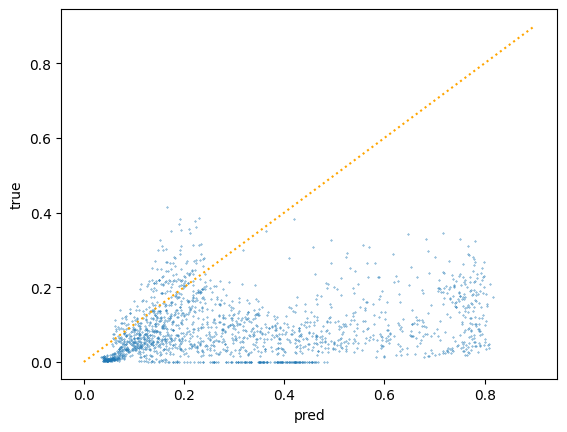

In [18]:
plt.scatter(y_hat.flatten(), y_test[:10].flatten(), s=0.1)
plt.plot(np.linspace(0, 0.9), np.linspace(0, 0.9), linestyle=':', color='orange')
plt.xlabel('pred')
plt.ylabel('true')

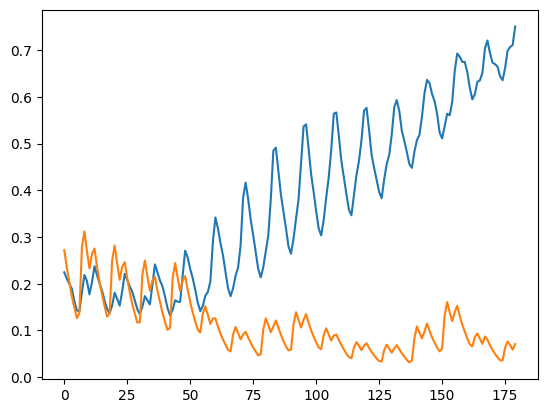

In [36]:
i = 7
plt.plot(range(180), y_hat[i,:,0])
plt.plot(range(180), y_test[i,:,0])

In [22]:
X_seq_test[1]

array([[0.55653692],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.71988925],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.25144463],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.53932505],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.   

In [24]:
X_train.iloc[1]

average_age      13813.923954
Q0                   0.444090
sigma_squared        2.150185
du                 502.549426
cd                   0.703748
gamma1               8.797417
cu                   0.167508
kb                   1.315091
ub                   1.798708
uc                   1.455753
ud                   3.716104
kc                   3.913809
b0                   0.454408
b1                   0.261650
ib0                 87.973853
ic0                 12.347062
dem                  5.896297
phi0                 0.153808
phi1                 0.486450
mum                  0.018373
fd0                  0.742438
ad               11110.319459
gammad               2.406528
g0                  -4.653532
g1                   6.770467
g2                   4.129381
g3                   1.087358
h1                  -2.485487
h2                   9.468975
h3                  -1.553890
EIR                  6.997299
Name: 36562, dtype: float64

In [12]:
import keras_tuner as kt

In [13]:
def bulid_hypermodel(hp):
    return create_transformer_modelmer_model(
        optimiser = hp.Choice(
            'optimiser',
            [
            Adam(
                TransformerSchedule(d_model),
                beta_1=0.9,
                beta_2=0.98,
                epsilon=1e-9
            ),
            'adam'
        ]),
        n_layer = hp.Int('n_layer', min_value=1, max_value=5, step=1),
        d_model = hp.Int("d_model", min_value=32, max_value=512, step=32),
        n_latent = hp.Int("n_latent", min_value=32, max_value=512, step=32),
        num_heads = hp.Int('num_heads', min_value=1, max_value=5, step=1),
        dropout = hp.Float("dropout", min_value=0., max_value=.2, step=.1),
        n_static_features = n_features,
        n_seq_features = 1,
        n_outputs = 1
    )

In [14]:
tuner = kt.Hyperband(
    hypermodel=bulid_hypermodel,
    objective="val_mse",
    max_epochs=100,
    seed=42,
    overwrite=True,
    directory="hyperparameters",
    project_name="det",
)

In [15]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
n_hidden (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': None}
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.2, 'step': 0.01, 'sampling': None}
loss (Choice)
{'default': 'mse', 'conditions': [], 'values': ['mse', 'log_cosh'], 'ordered': False}
hidden_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu'], 'ordered': False}
output_activation (Choice)
{'default': 'linear', 'conditions': [], 'values': ['linear', 'softmax'], 'ordered': False}


In [16]:
X_hyp_train, X_hyp_val, y_hyp_train, y_hyp_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=seed
)

In [17]:
tuner.search(
    X_hyp_train,
    y_hyp_train,
    validation_data=(X_hyp_val, y_hyp_val),
    callbacks=[tf.keras.callbacks.EarlyStopping("mse", min_delta=1e-10, patience=5)]
)

Trial 230 Complete [00h 02m 17s]
val_mse: 0.00022005359642207623

Best val_mse So Far: 9.33476330828853e-05
Total elapsed time: 02h 25m 44s

Search: Running Trial #231

Value             |Best Value So Far |Hyperparameter
4                 |4                 |n_hidden
192               |96                |units
0.02              |0                 |dropout
mse               |mse               |loss
elu               |elu               |hidden_activation
linear            |linear            |output_activation
34                |100               |tuner/epochs
12                |34                |tuner/initial_epoch
2                 |4                 |tuner/bracket
1                 |4                 |tuner/round
0225              |0144              |tuner/trial_id

Epoch 13/34
2000/2000 [==============================] - 7s 3ms/step - loss: 0.0174 - mse: 0.0174 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 14/34
2000/2000 [==============================] - 7s 3ms/step - loss: 0.0023 - 

KeyboardInterrupt: 

623/623 [==============================] - 1s 1ms/step


Text(0, 0.5, 'true')

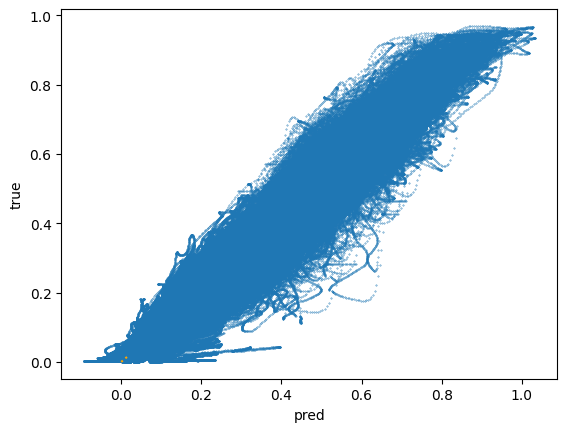

In [38]:
bm = tuner.get_best_models(num_models=1)[0]
y_hat = model.predict(X_test)
plt.scatter(y_hat.flatten(), y_test.to_numpy().flatten(), s=0.1)
plt.plot(np.linspace(0, 0.02), np.linspace(0, 0.02), linestyle=':', color='orange')
plt.xlabel('pred')
plt.ylabel('true')

In [39]:
tuner.results_summary()

Results summary
Results in hyperparameters/eq
Showing 10 best trials
Trial summary
Hyperparameters:
n_hidden: 4
units: 128
dropout: 0.09
loss: log_cosh
hidden_activation: elu
output_activation: linear
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 0143
Score: 0.0011498170206323266
Trial summary
Hyperparameters:
n_hidden: 3
units: 96
dropout: 0.07
loss: log_cosh
hidden_activation: elu
output_activation: linear
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0238
Score: 0.0012141329934820533
Trial summary
Hyperparameters:
n_hidden: 3
units: 192
dropout: 0.04
loss: mse
hidden_activation: relu
output_activation: linear
tuner/epochs: 34
tuner/initial_epoch: 12
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0219
Score: 0.0015096659772098064
Trial summary
Hyperparameters:
n_hidden: 3
units: 96
dropout: 0.09
loss: log_cosh
hidden_activation: elu
output_activation: linear
tuner/epochs: 100
tuner/initial_epoch:

In [30]:
model.save('models/det_sequence')

INFO:tensorflow:Assets written to: models/det_sequence/assets


INFO:tensorflow:Assets written to: models/det_sequence/assets
